In [1]:
import pandas as pd
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import torch
import optuna
import torch_geometric.transforms as T
from sklearn.neural_network import MLPClassifier 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from torch_geometric.data import NeighborSampler
from torch.optim import lr_scheduler
import torch.optim as optim
import collections
import numpy as np
from modules.model import Net
from sklearn.metrics import f1_score
from modules.sampling import Sampler, SamplerContextMatrix, SamplerRandomWalk,SamplerFactorization,SamplerAPP
from datetime import datetime
import random
from torch_geometric.data import GraphSAINTNodeSampler
import pickle
import os
from torch_geometric.data import Data
import collections
from torch_geometric.datasets import Planetoid,WikipediaNetwork,Actor,WebKB

In [2]:
import pandas as pd
import collections
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
analysis = pd.read_csv('../results/final_data.csv')
analysis = analysis.drop(columns='Unnamed: 0')

In [4]:
supervised = pd.read_csv('../results/supervised.csv')
supervised = supervised.drop(columns='Unnamed: 0')

In [5]:
supervised = supervised[supervised['conv']=='GCN']

In [6]:
supervised['loss']=['no']*len(supervised)

In [7]:
datasets = supervised['dataset'].tolist()

In [8]:
sup_GCN = supervised['test acc micro'].tolist()

In [9]:
unsup_GCN=[]
features_GCN=[]

In [13]:
analysis_GCN=analysis[analysis['conv']=='GCN']
#analysis_GCN=analysis_GCN.groupby(['dataset']).max()['test acc micro'].reset_index()

In [36]:
analysis_GCN


,loss,conv,dataset,train acc micro,test acc micro,train acc macro,test acc macro,label assortativity,feature assortativity,cluster coefficient,average shortest path,average degree,group
182,HOPE_Katz,GCN,0.10.10.225,0.697575,0.155779,0.696474,0.152992,0.1,0.1,0.2,2.0,5.0,1.0
185,HOPE_Katz,GCN,0.10.10.2220,0.560628,0.195980,0.561337,0.196158,0.1,0.1,0.2,2.0,20.0,1.0
188,HOPE_Katz,GCN,0.10.10.2240,0.383738,0.130653,0.380888,0.126792,0.1,0.1,0.2,2.0,40.0,1.0
191,HOPE_Katz,GCN,0.10.10.232,0.342368,0.065327,0.341791,0.062845,0.1,0.1,0.2,3.0,2.0,1.0
194,HOPE_Katz,GCN,0.10.10.235,0.753210,0.105528,0.754964,0.098829,0.1,0.1,0.2,3.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7811,Force2Vec,GCN,0.90.90.5220,0.893010,0.974874,0.885376,0.974950,0.9,0.9,0.5,2.0,20.0,5.0
7814,Force2Vec,GCN,0.90.90.5240,0.985735,0.984925,0.985765,0.984968,0.9,0.9,0.5,2.0,40.0,5.0
7817,Force2Vec,GCN,0.90.90.535,0.399429,0.296482,0.398983,0.268423,0.9,0.9,0.5,3.0,5.0,5.0
7820,Force2Vec,GCN,0.90.90.5320,0.659058,0.256281,0.665771,0.259185,0.9,0.9,0.5,3.0,20.0,5.0


In [57]:
new_analysis = pd.DataFrame(columns=analysis_GCN.columns)

for dataset in supervised['dataset'].tolist():
    if len(analysis_GCN[analysis_GCN['dataset']==dataset])>0:
        analysis_df = analysis_GCN[analysis_GCN['dataset']==dataset].reset_index()
        analysis_df['test acc micro']=analysis_df['test acc micro'].apply(lambda x: x - supervised[supervised['dataset'] == dataset]['test acc micro'].values[0])
        new_analysis = new_analysis.append(analysis_df)

In [102]:
dfs=[]
for feature in ['average degree', 'average shortest path','cluster coefficient','feature assortativity','label assortativity']:
    df = new_analysis[['loss','test acc micro',feature]]

    df=df.groupby(by=['loss',feature]).mean()
    df = df.unstack(feature)
    df['newlevel'] = feature
    df=df.set_index('newlevel', append=True).unstack('newlevel')

    if feature == 'average degree':
        df=df.sort_values(by=[('test acc micro', 5.0, 'average degree')],ascending=False)
        index_order = df.index.tolist()
    #print(df)
    df=df.reindex(index_order)
    dfs.append(df)


In [103]:
data_to_heatmap = pd.concat(dfs, axis=1)

<AxesSubplot:xlabel='None-average degree-newlevel', ylabel='loss'>

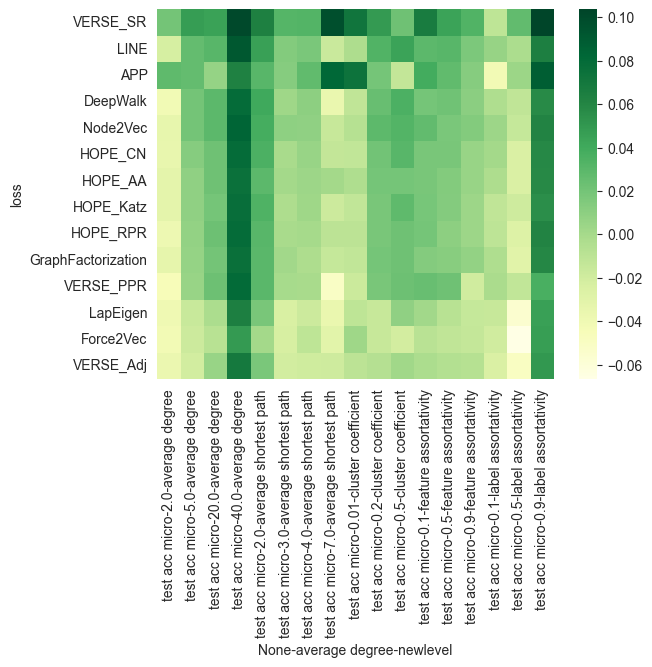

In [105]:
sns.heatmap(data_to_heatmap,cmap='YlGn')

In [19]:
analysis_GCN

,loss,conv,dataset,train acc micro,test acc micro,train acc macro,test acc macro,label assortativity,feature assortativity,cluster coefficient,average shortest path,average degree,group
182,HOPE_Katz,GCN,0.10.10.225,0.697575,0.155779,0.696474,0.152992,0.1,0.1,0.2,2.0,5.0,1.0
185,HOPE_Katz,GCN,0.10.10.2220,0.560628,0.195980,0.561337,0.196158,0.1,0.1,0.2,2.0,20.0,1.0
188,HOPE_Katz,GCN,0.10.10.2240,0.383738,0.130653,0.380888,0.126792,0.1,0.1,0.2,2.0,40.0,1.0
191,HOPE_Katz,GCN,0.10.10.232,0.342368,0.065327,0.341791,0.062845,0.1,0.1,0.2,3.0,2.0,1.0
194,HOPE_Katz,GCN,0.10.10.235,0.753210,0.105528,0.754964,0.098829,0.1,0.1,0.2,3.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7811,Force2Vec,GCN,0.90.90.5220,0.893010,0.974874,0.885376,0.974950,0.9,0.9,0.5,2.0,20.0,5.0
7814,Force2Vec,GCN,0.90.90.5240,0.985735,0.984925,0.985765,0.984968,0.9,0.9,0.5,2.0,40.0,5.0
7817,Force2Vec,GCN,0.90.90.535,0.399429,0.296482,0.398983,0.268423,0.9,0.9,0.5,3.0,5.0,5.0
7820,Force2Vec,GCN,0.90.90.5320,0.659058,0.256281,0.665771,0.259185,0.9,0.9,0.5,3.0,20.0,5.0


In [12]:
features_GCN=[]
unsup_GCN=[]


for k,dat in enumerate(datasets):
    value_array = analysis_GCN[analysis_GCN['dataset'] == dat]['test acc micro'].values
    if len(value_array)==0:
        print('unsup',dat)
        l=k
    else:
        unsup_GCN.append(value_array.tolist()[0])
    #if len(analysis[(analysis['conv']=='features')&(analysis['dataset']==dat)]['test acc micro'])>0:
#    print(dat)
 #   print(analysis[(analysis['loss']=='features')&(analysis['dataset']==dat)]['test acc micro'])
    value_array = analysis[(analysis['loss']=='features')&(analysis['dataset']==dat)]['test acc micro'].values
    if len(value_array)==0:
        print(dat)
    else:
       features_GCN.append(value_array.tolist()[0])
features_GCN

unsup 0.10.90.2535
0.10.90.2535


[0.0904522613065326,
 0.0452261306532663,
 0.0402010050251256,
 0.0603015075376884,
 0.0703517587939698,
 0.1105527638190954,
 0.0703517587939698,
 0.1105527638190954,
 0.0653266331658291,
 0.050251256281407,
 0.0452261306532663,
 0.1055276381909547,
 0.0452261306532663,
 0.1055276381909547,
 0.0552763819095477,
 0.0653266331658291,
 0.0954773869346733,
 0.0603015075376884,
 0.0804020100502512,
 0.0603015075376884,
 0.0904522613065326,
 0.1758793969849246,
 0.0703517587939698,
 0.0452261306532663,
 0.0804020100502512,
 0.1105527638190954,
 0.0954773869346733,
 0.1105527638190954,
 0.0703517587939698,
 0.0703517587939698,
 0.0703517587939698,
 0.0703517587939698,
 0.100502512562814,
 0.1608040201005025,
 0.1105527638190954,
 0.1256281407035175,
 0.0854271356783919,
 0.0402010050251256,
 0.0753768844221105,
 0.1256281407035175,
 0.0653266331658291,
 0.1155778894472361,
 0.2060301507537688,
 0.2311557788944723,
 0.2562814070351759,
 0.5226130653266332,
 0.4824120603015075,
 0.366834170854

In [102]:
sup_GCN=sup_GCN[:l]+sup_GCN[l+1:]

In [103]:
indices = torch.tensor(features_GCN).argsort(descending=False)

In [104]:
sup_GCN_torch=torch.tensor(sup_GCN)[indices].tolist()
unsup_GCN_torch=torch.tensor(unsup_GCN)[indices].tolist()
features_GCN_torch=torch.tensor(features_GCN)[indices].tolist()

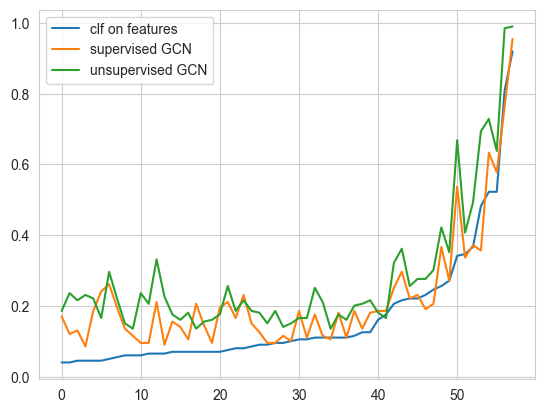

In [112]:
import matplotlib.pyplot as plt
#ig = px.line(gcn_x)
plt.plot(features_GCN_torch,label='clf on features')
plt.plot(sup_GCN_torch,label='supervised GCN')
plt.plot(unsup_GCN_torch,label='unsupervised GCN')
plt.legend()

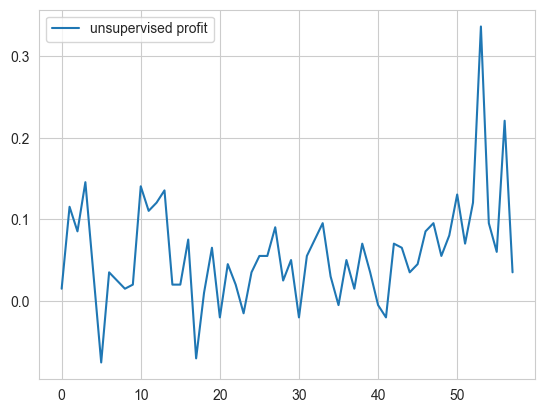

In [114]:
import matplotlib.pyplot as plt
#ig = px.line(gcn_x)
plt.plot(np.array(unsup_GCN_torch)-np.array(sup_GCN_torch),label='unsupervised profit')
plt.legend()

In [ ]:
#список функций потерь и характеристик графа
df=pd.read_csv('../results/final_data.csv')
df=df.drop(columns=['Unnamed: 0'])
losses=list(dict(collections.Counter(df['loss'])).keys())

attrs=['label assortativity', 'feature assortativity', 'cluster coefficient', 'average shortest path', 'average degree']


In [ ]:
df_1 = df.groupby(['conv','dataset']).mean()
df_1=df_1.reset_index()

In [ ]:
gat_test = df_1[df_1['conv']=='GAT']['test acc micro'].tolist()
gcn_test = df_1[df_1['conv']=='GCN']['test acc micro'].tolist()
sage_test = df_1[df_1['conv']=='SAGE']['test acc micro'].tolist()
no_test = df_1[df_1['conv']=='no']['test acc micro'].tolist()

In [ ]:
indices = torch.tensor(no_test).argsort(descending=False)

In [ ]:
sage_x=torch.tensor(sage_test)[indices].tolist()
gcn_x=torch.tensor(gcn_test)[indices].tolist()
gat_x=torch.tensor(gat_test)[indices].tolist()
no_x=torch.tensor(no_test)[indices].tolist()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
#ig = px.line(gcn_x)
fig = go.Figure()
fig.add_trace(go.Scatter(x=no_x,
                    mode='markers',
                    name='clf on features', marker =dict(size = 5, color = 'orange')))

fig.add_trace(go.Scatter(x=gcn_x,
                    mode='markers',
                    name='GCN', marker =dict(size = 5)))

fig.add_trace(go.Scatter(x=gat_x,
                    mode='markers',
                    name='GAT', marker =dict(size = 5)),)


fig.add_trace(go.Scatter(x=sage_x,
                    mode='markers',
                    name='SAGE', marker =dict(size = 5)))
fig.update_layout(plot_bgcolor="white")
fig.show()

In [ ]:
df=pd.read_csv('../results/final_data.csv')
df=df.drop(columns=['Unnamed: 0'])

In [ ]:
font = {'size' : 25}
matplotlib.rc('font', **font)

### тут я считаю корреляцию между результатами с использованием разных функций потерь. Это относится к Results and Discussion 4 point начинающийся со слов "pearson correlation"

In [ ]:
from scipy.stats import kendalltau as Kcorr
from scipy.stats import pearsonr as Pcorr

In [ ]:

df=pd.read_csv('final_data.csv')
df=df.drop(columns=['Unnamed: 0'])

losses = list(dict(collections.Counter(df['loss'])).keys())

su=0
ff=0
for i,loss1 in enumerate(losses):
    for loss2 in losses[i+1:]:
       # print(loss1,loss2)
        su+=1
        x=df[(df['loss']==loss1) & (df['conv'] == 'GCN' )]['test acc micro']
        y=df[(df['loss']==loss2) & (df['conv'] == 'GCN' )]['test acc micro']
        if Pcorr(x,y)[0]<0.98:
            ff+=1   
print(ff,su)


# COMPARISON OF DENSITY OF BENCHMARK SPACE - figure 2

In [ ]:
df_2 = pd.read_excel('benchmark_space_ideal.xlsx')

In [ ]:
import pandas as pd
import collections
df=pd.read_csv('final_data.csv')
df=df.drop(columns=['Unnamed: 0'])

In [ ]:
font = {'size' : 20}
matplotlib.rc('font', **font)

In [ ]:
fig2=px.parallel_coordinates(df,dimensions=['label assortativity', 'feature assortativity', 'cluster coefficient', 'average shortest path', 'average degree'])
fig2.update_layout(
    font=dict(
        size=22,  # Set the font size here
        color = 'black'
    )
)

fig2.show()

In [ ]:
fig2=px.parallel_coordinates(df_2,dimensions=['label assortativity', 'feature assortativity', 'cluster coefficient', 'average shortest path', 'average degree'])
fig2.update_layout(
    font=dict(
        size=22,  # Set the font size here
        color = 'black'
    )
)

fig2.show()

# heatmaps - рисунок три 

In [ ]:
df=pd.read_csv('final_data.csv')
df=df.drop(columns=['Unnamed: 0'])

df_analysis = df.groupby(['group','label assortativity']).mean()['test acc micro']
df_analysis = df_analysis.unstack('label assortativity')
df_analysis['newlevel'] = 'label assortativity'
df_analysis=df_analysis.set_index('newlevel', append=True).unstack('newlevel')

for attr in attrs:
    df_1 = df.groupby(['group',attr]).mean()['test acc micro']
    df_1 = df_1.unstack(attr)
    df_1['newlevel'] = attr
    df_1 = df_1.set_index('newlevel', append=True).unstack('newlevel')
    
    df_analysis = pd.merge(df_analysis,df_1,on=['group'],how='left')


In [ ]:
for attr in ['label assortativity']+attrs:
    df_1 = df.groupby(['group',attr]).mean()['test acc macro']
    df_1 = df_1.unstack(attr)
    sns.heatmap(df_1,cmap='GnBu')
    plt.title('macro')
    plt.show()

# Global Ranking (таблицы из апендикса)

In [ ]:
df_analysis = df.groupby(['group','loss','label assortativity']).std()['test acc micro']

df_analysis = df_analysis.unstack('label assortativity')
df_analysis['newlevel'] = 'label assortativity'
df_analysis=df_analysis.set_index('newlevel', append=True).unstack('newlevel')

for attr in attrs[1:]:
    df_1 = df.groupby(['group','loss',attr]).std()['test acc micro']
    df_1 = df_1.unstack(attr)
    df_1['newlevel'] = attr
    df_1 = df_1.set_index('newlevel', append=True).unstack('newlevel')
    
    df_analysis = pd.merge(df_analysis,df_1,on=['group','loss'],how='left')

df_analysis=df_analysis.round(decimals=2)
df_analysis

In [ ]:
df_analysis = df.groupby(['group','loss','label assortativity']).mean()['test acc micro']

df_analysis = df_analysis.unstack('label assortativity')
df_analysis['newlevel'] = 'label assortativity'
df_analysis=df_analysis.set_index('newlevel', append=True).unstack('newlevel')

for attr in attrs[1:]:
    df_1 = df.groupby(['group','loss',attr]).mean()['test acc micro']
    df_1 = df_1.unstack(attr)
    df_1['newlevel'] = attr
    df_1 = df_1.set_index('newlevel', append=True).unstack('newlevel')
    
    df_analysis = pd.merge(df_analysis,df_1,on=['group','loss'],how='left')

df_analysis=df_analysis.round(decimals=2)
df_analysis

# la=0.1

In [ ]:
df_analysis = df[(df['label assortativity']==0.1) ]

df_analysis = df_analysis.groupby(['group','loss','feature assortativity']).mean()['test acc micro']
df_analysis = df_analysis.unstack('feature assortativity')
df_analysis['newlevel'] = 'feature assortativity'
df_analysis=df_analysis.set_index('newlevel', append=True).unstack('newlevel')

for attr in attrs[2:]:
    df_1 =  df[(df['label assortativity']==0.1) ].groupby(['group','loss',attr]).mean()['test acc micro']
    df_1 = df_1.unstack(attr)
    df_1['newlevel'] = attr
    df_1 = df_1.set_index('newlevel', append=True).unstack('newlevel')
    
    df_analysis = pd.merge(df_analysis,df_1,on=['group','loss'],how='left')

df_analysis=df_analysis.round(decimals=2)
df_analysis

In [ ]:
df_analysis = df[(df['label assortativity']==0.1)]

df_analysis = df_analysis.groupby(['group','loss','feature assortativity']).std()['test acc micro']
df_analysis = df_analysis.unstack('feature assortativity')
df_analysis['newlevel'] = 'feature assortativity'
df_analysis=df_analysis.set_index('newlevel', append=True).unstack('newlevel')

for attr in attrs[2:]:
    df_1 =  df[(df['label assortativity']==0.1) ].groupby(['group','loss',attr]).std()['test acc micro']
    df_1 = df_1.unstack(attr)
    df_1['newlevel'] = attr
    df_1 = df_1.set_index('newlevel', append=True).unstack('newlevel')
    
    df_analysis = pd.merge(df_analysis,df_1,on=['group','loss'],how='left')

df_analysis=df_analysis.round(decimals=2)
df_analysis

# la=0.5

In [ ]:
df_analysis = df[(df['label assortativity']==0.5)]
df_analysis = df_analysis.groupby(['group','loss','feature assortativity']).mean()['test acc micro']
df_analysis = df_analysis.unstack('feature assortativity')
df_analysis['newlevel'] = 'feature assortativity'
df_analysis=df_analysis.set_index('newlevel', append=True).unstack('newlevel')

for attr in attrs[2:]:
    df_1 = df[(df['label assortativity']==0.5)].groupby(['group','loss',attr]).mean()['test acc micro']
    df_1 = df_1.unstack(attr)
    df_1['newlevel'] = attr
    df_1 = df_1.set_index('newlevel', append=True).unstack('newlevel')
    
    df_analysis = pd.merge(df_analysis,df_1,on=['group','loss'],how='left')
df_analysis=df_analysis.round(decimals=2)
df_analysis

In [ ]:
df_analysis = df[(df['label assortativity']==0.5)]
df_analysis = df_analysis.groupby(['group','loss','feature assortativity']).std()['test acc micro']
df_analysis = df_analysis.unstack('feature assortativity')
df_analysis['newlevel'] = 'feature assortativity'
df_analysis=df_analysis.set_index('newlevel', append=True).unstack('newlevel')

for attr in attrs[2:]:
    df_1 = df[(df['label assortativity']==0.5) ].groupby(['group','loss',attr]).std()['test acc micro']
    df_1 = df_1.unstack(attr)
    df_1['newlevel'] = attr
    df_1 = df_1.set_index('newlevel', append=True).unstack('newlevel')
    
    df_analysis = pd.merge(df_analysis,df_1,on=['group','loss'],how='left')
df_analysis=df_analysis.round(decimals=2)
df_analysis

# la=0.9

In [ ]:
df_analysis = df[(df['label assortativity']==0.9) ]
df_analysis = df_analysis.groupby(['group','loss','feature assortativity']).mean()['test acc micro']
df_analysis = df_analysis.unstack('feature assortativity')
df_analysis['newlevel'] = 'feature assortativity'
df_analysis=df_analysis.set_index('newlevel', append=True).unstack('newlevel')

for attr in attrs[2:]:
    df_1 = df[(df['label assortativity']==0.9)].groupby(['group','loss',attr]).mean()['test acc micro']
    df_1 = df_1.unstack(attr)
    df_1['newlevel'] = attr
    df_1 = df_1.set_index('newlevel', append=True).unstack('newlevel')
    
    df_analysis = pd.merge(df_analysis,df_1,on=['group','loss'],how='left')
df_analysis=df_analysis.round(decimals=2)
df_analysis.transpose()

In [ ]:
df_analysis = df[(df['label assortativity']==0.9) ]
df_analysis = df_analysis.groupby(['group','loss','feature assortativity']).std()['test acc micro']
df_analysis = df_analysis.unstack('feature assortativity')
df_analysis['newlevel'] = 'feature assortativity'
df_analysis=df_analysis.set_index('newlevel', append=True).unstack('newlevel')

for attr in attrs[2:]:
    df_1 = df[(df['label assortativity']==0.9) ].groupby(['group','loss',attr]).std()['test acc micro']
    df_1 = df_1.unstack(attr)
    df_1['newlevel'] = attr
    df_1 = df_1.set_index('newlevel', append=True).unstack('newlevel')
    
    df_analysis = pd.merge(df_analysis,df_1,on=['group','loss'],how='left')
df_analysis=df_analysis.round(decimals=2)
df_analysis

# Global ranking (таблица 4)

In [ ]:
import pandas as pd
import collections
df=pd.read_csv('../results/final_data.csv')
df=df.drop(columns=['Unnamed: 0'])

In [ ]:
df_2=pd.read_csv('../results/classification_on_features.csv')
df_2=df_2.drop(columns=['Unnamed: 0'])

In [ ]:
df_2['dataset']=df_2.apply(lambda x: str(x['la'])+str(x['fa'])+str(x['cl'])+str(x['asp'])+str(x['ad']), axis = 1)

In [ ]:
df=df.drop(columns = ['label assortativity','feature assortativity','cluster coefficient','average shortest path','average degree','group'])

In [ ]:
df_2 = df_2.drop(columns=['la','cl','fa','asp','ad'])

In [ ]:
df

In [ ]:
df.apply(lambda x: (x[2][:3]))

In [ ]:
df_groupby=[['conv','dataset','test acc micro']].groupby(['conv','dataset'],as_index=False).max()
df_merge = pd.merge(df_groupby,df,on=['conv','dataset','test acc micro'],how='left')
list_of_dicts=[]

for conv in ['GCN','GAT','SAGE']:
    orders = collections.Counter(df_merge[df_merge['conv']==conv]['loss'])
    list_of_dicts.append(orders)
new_dict=list_of_dicts[0]+list_of_dicts[1]+list_of_dicts[2]

global_rank=(sorted(new_dict.items(), key=lambda x: x[1], reverse=True))
rank_GCN=(sorted(list_of_dicts[0].items(), key=lambda x: x[1], reverse=True))
rank_GAT=(sorted(list_of_dicts[1].items(), key=lambda x: x[1], reverse=True))
rank_SAGE=(sorted(list_of_dicts[2].items(), key=lambda x: x[1], reverse=True))
print(rank_GCN,global_rank)

In [ ]:
dict(rank_GCN)

# Line Graphs рисунок 4

In [ ]:

df=pd.read_csv('final_data.csv')
df=df.drop(columns=['Unnamed: 0'])

In [ ]:

for feat in attrs:
    fig = plt.figure()
    ax = plt.subplot(111)
    for conv in ['GCN','GAT','SAGE']:
        plt.plot( list(df[ (df['conv'] == conv)].groupby(feat).mean().index),  df[(df['conv']==conv)].groupby(feat).mean()['test acc micro'],label=conv,marker='*', linewidth = 1)
    ax.grid(False)
    ax.set_ylim([0.05,0.75])
    ax.legend(bbox_to_anchor=(1.1, 0.9))

    plt.title(feat)
    plt.show()


# boxplots (только для GCN) рисунки 6-8

In [ ]:
#не все ф.п. рассматриваем
df=pd.read_csv('final_data.csv')
df=df.drop(columns=['Unnamed: 0'])
df_boxplots = df[(df['loss' ]=='VERSE_Adj')|(df['loss']=='HOPE_RPR') | (df['loss']=='LapEigen') | (df['loss']=='VERSE_SR') | (df['loss' ]=='DeepWalk')| (df['loss' ]=='Force2Vec')]
features=['label assortativity','feature assortativity','cluster coefficient','average shortest path','average degree']

### рисунок 5

In [ ]:
font = {'size' : 25}
matplotlib.rc('font', **font)

my_pal = {"HOPE_RPR": "steelblue", "LapEigen": "darkorange", "DeepWalk": "darkseagreen","VERSE_Adj":"mediumpurple","VERSE_SR":"indianred","Force2Vec":'darkgray'}
for attr in attrs: 
        sns.boxplot(data=df_boxplots[(df_boxplots['conv']=='GCN')], x=attr,y="test acc micro" , width=0.6, hue="loss",palette=my_pal,fliersize=2)
        #fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
        plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
        plt.show() 

### для label assortativity 0.1 рисунок 6

In [ ]:
font = {'size' : 25}
matplotlib.rc('font', **font)

my_pal = {"HOPE_RPR": "steelblue", "LapEigen": "darkorange", "DeepWalk": "darkseagreen","VERSE_Adj":"mediumpurple","VERSE_SR":"indianred","Force2Vec":'darkgray'}
for attr in attrs: 
        sns.boxplot(data=df_boxplots[(df_boxplots['label assortativity']==0.1)&(df_boxplots['conv']=='GCN')], x=attr,y="test acc micro" , width=0.6, hue="loss",palette=my_pal,fliersize=2)
        #fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
        plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
        plt.show() 

### для label assortativity = 0.5

In [ ]:
for attr in attrs: 
        sns.boxplot(data=df_boxplots[(df_boxplots['label assortativity']==0.5)&(df_boxplots['conv']=='GCN')], x=attr,y="test acc micro" , width=0.6, hue="loss",palette=my_pal,fliersize=2)
        #fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
        plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
        plt.show() 

### для label assortativity = 0.9

In [ ]:
for attr in attrs: 
        sns.boxplot(data=df_boxplots[(df_boxplots['label assortativity']==0.9)&(df_boxplots['conv']=='GCN')], x=attr,y="test acc micro" , width=0.6, hue="loss",palette=my_pal,fliersize=2)
        #fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
        plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
        plt.show() 

# Statistically significant difference - discussion and results 2 point начинающийся со слов "In one of the benchmarking representation learning papers "

In [ ]:
#ANOVA
losses=list(dict(collections.Counter(df['loss'])).keys())
import scipy.stats as stats
to_test = []
for loss in losses:
    to_test.append(df[df['loss']==loss]['test acc micro'])

fvalue, pvalue = stats.f_oneway(to_test[0],to_test[1],to_test[2],to_test[3],to_test[4],to_test[5],to_test[6],to_test[7],to_test[8],to_test[9],to_test[10],to_test[11],to_test[12])
#fvalue, pvalue = stats.f_oneway(df[df['loss']=='HOPE_Katz']['test acc micro'],df[df['loss']=='HOPE_CN']['test acc micro'], df[df['loss']=='HOPE_RPR']['test acc micro'], df[df['loss']=='LapEigen']['test acc micro'],df[df['loss']=='LINE']['test acc micro'],df[df['loss']=='VERSE_PPR']['test acc micro'], df[df['loss']=='GraphFactorization']['test acc micro'], df[df['loss']=='HOPE_AA']['test acc micro'], df[df['loss']=='Node2Vec']['test acc micro'], df[df['loss']=='VERSE_Adj']['test acc micro'],df[df['loss']=='DeepWalk']['test acc micro'],df[df['loss']=='APP']['test acc micro'],df[df['loss']=='VERSE_SR']['test acc micro'])


In [ ]:
#внутри группы GF
fvalue, pvalue = stats.f_oneway(to_test[0],to_test[1],to_test[2],to_test[6],to_test[7])
print(pvalue<0.05)

In [ ]:
#внутри группы RandomWalks
fvalue, pvalue = stats.f_oneway(to_test[1],to_test[8])
print(pvalue<0.05)

In [ ]:
#внутри группы matrix sim
fvalue, pvalue = stats.f_oneway(to_test[4],to_test[5],to_test[9],to_test[11],to_test[12])
print(pvalue<0.05)

In [ ]:
import numpy as np
from scipy.stats import ttest_ind

losses_2=['LINE','VERSE_SR','VERSE_PPR','VERSE_Adj','APP']
for i,loss1 in enumerate(losses_2):
    for loss2 in losses_2[i+1:]:
       # print(loss1,loss2)
       # print(loss)
        v1 = df[df['loss']==loss1]['test acc micro']
        v2 = df[df['loss']==loss2]['test acc micro']

        res = ttest_ind(v1, v2)

        if (res.pvalue <= 0.05):
            print(loss1,loss2)

# ВЫБИВАЕТСЯ ТОЛЬКО VERSE ADJ

## ниже идет то что я писала в главе "comparison with real graphs" в пункте 3. 
## если std маленький и max Тоже не очень большой, значит результат плохой независимо от ф.п. а просто для таких данных плохой

In [ ]:

df=pd.read_csv('data_analysis_realdata.csv')
df=df.drop(columns=['Unnamed: 0'])
df

(df[(df['dataset']=='Cora') & (df['conv']=='GCN')]['test acc micro'].max(),df[(df['dataset']=='Cora') & (df['conv']=='GCN')]['test acc micro'].std())

In [ ]:
(df[(df['dataset']=='Citeseer') & (df['conv']=='GCN')]['test acc micro'].max(),df[(df['dataset']=='Citeseer') & (df['conv']=='GCN')]['test acc micro'].std())

In [ ]:
(df[(df['dataset']=='Cornell') & (df['conv']=='GCN')]['test acc micro'].max(),df[(df['dataset']=='Cornell') & (df['conv']=='GCN')]['test acc micro'].std())

In [ ]:
(df[(df['dataset']=='chameleon') & (df['conv']=='GCN')]['test acc micro'].max(), df[(df['dataset']=='chameleon') & (df['conv']=='GCN')]['test acc micro'].std())

In [ ]:
(df[(df['dataset']=='Wisconsin') & (df['conv']=='GCN') ]['test acc micro'].max(),df[(df['dataset']=='Wisconsin') & (df['conv']=='GCN') ]['test acc micro'].std())

In [ ]:
(df[(df['dataset']=='Texas') & (df['conv']=='GCN') ]['test acc micro'].max() ,df[(df['dataset']=='Texas') & (df['conv']=='GCN') ]['test acc micro'].std())

# на фичах

In [ ]:
df=pd.read_csv('../results/final_data_with_features.csv')
df=df.drop(columns=['Unnamed: 0'])
attrs=['fa','la', 'cl', 'asp', 'ad']

In [ ]:
df

In [ ]:
losses

In [ ]:
df_analysis = df[(df['fa']==0.5)]
df_2 = df_analysis.groupby(['fa']).mean()['test acc micro']
print(df_2)

for attr in ['fa','la']:
    df_1 =  df[(df['la']==0.5)].groupby([attr]).mean()['test acc micro']
    #df_1 = df_1.unstack(attr)
    #df_1['newlevel'] = attr
    #df_1 = df_1.set_index('newlevel', append=True).unstack('newlevel')
    print(df_1)
   # df_analysis = pd.merge(df_analysis,df_1,how='left')

df_analysis=df_analysis.round(decimals=2)
#df_analysis

In [ ]:
df_analysis = df[(df['la']==0.5)]
df_2 = df_analysis.groupby(['fa']).std()['test acc micro']
print(df_2)

#df_analysis = df_analysis.unstack(['fa'])
#df_analysis['newlevel'] = 'fa'

#df_analysis=df_analysis.set_index('newlevel', append=True).unstack('newlevel')

for attr in attrs[1:]:
    df_1 =  df[(df['la']==0.5)].groupby([attr]).std()['test acc micro']
    #df_1 = df_1.unstack(attr)
    #df_1['newlevel'] = attr
    #df_1 = df_1.set_index('newlevel', append=True).unstack('newlevel')
    print(df_1)
   # df_analysis = pd.merge(df_analysis,df_1,how='left')

df_analysis=df_analysis.round(decimals=2)
#df_analysis

In [ ]:
df[(df['fa']==0.1) & (df['conv']=='GCN')].groupby(['loss']).mean().sort_values(by=['test acc micro'], ascending=False).index

In [ ]:
df_5 = df[(df['la']==0.5) & (df['conv']=='GCN')].groupby(['loss','fa']).mean()['test acc micro']
df_5 = df_5.unstack('fa')
df_5=df_5.sort_values(by=[0.5], ascending=False)
#df_55['newlevel'] = 'fa'
#df_55 = df_55.set_index('newlevel', append=True).unstack('newlevel')
df_5

In [ ]:
losses = list(df_5.index)

df_1 = df[(df['la']==0.1) & (df['conv']=='GCN')].groupby(['loss','fa']).mean()['test acc micro']
df_1 = df_1.unstack('fa')
df_1=df_1.reindex(losses,axis=0)

df_9 = df[(df['la']==0.9) & (df['conv']=='GCN')].groupby(['loss','fa']).mean()['test acc micro']
df_9 = df_9.unstack('fa')
df_9=df_9.reindex(losses,axis=0)


In [ ]:
df_1

In [ ]:
normalized_df=(df_1-df_1.min())/(df_1.max()-df_1.min())

In [ ]:
df_1=normalized_df

In [ ]:
f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4,
            gridspec_kw={'width_ratios':[1,1,1,0.08]})

ax1.get_shared_y_axes().join(ax2,ax3)
g1=sns.heatmap(df_1,annot=True,vmin=0,vmax =0.9, cbar=False, ax = ax1)
g1.set_ylabel('')
g1.set_xlabel('feature assortativity')
g1.set_title('label assortativity = 0.1',fontsize = 11)
g2=sns.heatmap(df_5,annot=True,vmin=0,vmax =0.9, cbar=False, ax = ax2)
g2.set_ylabel('')
g2.set_xlabel('feature assortativity')
g2.set_title('label assortativity = 0.5',fontsize = 11)
g2.set_yticks([])
g3=sns.heatmap(df_9,annot=True,vmin=0,vmax =0.9,cbar_ax=axcb, ax = ax3)
g3.set_ylabel('')
g3.set_xlabel('feature assortativity')
g3.set_title('label assortativity = 0.9',fontsize = 11)
g3.set_yticks([])
sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
plt.show()

#ax1.set_xlabel('feature assortativity')

In [ ]:
font = {'size' : 12}
matplotlib.rc('font', **font)